# Imports

Importando las capas necesarias para este problema

In [0]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, PReLU
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization as BN
from keras.layers import GaussianNoise as GN
from keras.optimizers import SGD

Using TensorFlow backend.


# Dataset

Descargar el dataset de amazon y preprocesarlo para darle la forma que requiere la red. Cambiar el tipo de dato a float de 32 bits y normalizar a valores entre 0 y 1 para las imágenes de entrada. Para las salidas transoformarlas a "one-hot" vector.

In [0]:
num_classes=10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print(x_train.shape)
print(x_test.shape)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

170500096/170498071 [==============================] - 25s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


# Data Augmentation


In [0]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
  featurewise_center=True,
  featurewise_std_normalization=True,
  width_shift_range=0.2,
  height_shift_range=0.2,
  rotation_range=20,
  zoom_range=[1.0,1.2],
  horizontal_flip=True)

datagen.fit(x_train)

testdatagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
)

testdatagen.fit(x_train)

# Callbacks

## Enfriamiento LR

Se prueban distintas técicas de enfriamiento del factor de aprendizaje.


1.   Decaimiento por pasos, reducir a la mitad cada 20 epocas.
2.   Enfriamiento programado donde especificamos en que época concreta queremos bajar el factor de aprendizaje y a que valor concreto.





In [0]:
from keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import math

# learning rate schedule
def step_decay(epoch,lr):
	initial_lrate = 0.1
	drop = 0.5
	epochs_drop = 20.0
	lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate

def scheduler(epoch):
  if epoch < 25:
    return .1
  elif epoch < 50:
    return 0.01
  else:
    return 0.001
  
def nin_scheduler(epoch):
  if epoch <= 60:
      return 0.05
  if epoch <= 120:
      return 0.01
  if epoch <= 160:
      return 0.002
  return 0.0004

lrate = LearningRateScheduler(step_decay)
lrate_nin = LearningRateScheduler(nin_scheduler)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              min_lr=0.0001,
                              patience=4)

## Guardar modelos

Callback para que guarde el modelo seiempre que mejore la precisión en el conjunto de validación.

In [0]:
from keras.callbacks import ModelCheckpoint
chkpoint = ModelCheckpoint('nin-{epoch:03d}-{val_acc:.2f}.hdf5', monitor='val_acc', save_best_only=True)

# Topologia

## Bloque convolucional

Función que construye un bloque convolucional. Primero una convolución de 3x3 y posteriormente aplicar la normalización del batch, el ruido gausiano, la activación y finalmente el resumen.

In [0]:
## DEF A BLOCK CONV + BN + GN + MAXPOOL
def CBGN(model,filters,ishape=0):
  if (ishape!=0):
    model.add(Conv2D(filters, (3, 3), padding='same',
                 input_shape=ishape))
  else:
    model.add(Conv2D(filters, (3, 3), padding='same'))
  
  model.add(BN())
  model.add(GN(0.3))
  model.add(PReLU())
  model.add(MaxPooling2D(pool_size=(2, 2)))
  
  return model

## ConvNN

Definición de la arquitectura. 5 bloques convolucionales con un número de filtros que aumenta con la profundidad de la red. Posteriormente aplanar el vector de salida de la parte convolucional y pasarlo  a las capas densas. Estas a su vez se les aplica el ruido gaussiano y la normalización.
Para las activaciones se usa la ReLU parametrizada, para aprender el 

In [0]:
model = Sequential()

model=CBGN(model,32,x_train.shape[1:])
model=CBGN(model,64)
model=CBGN(model,128)
model=CBGN(model,256)
model=CBGN(model,512)

model.add(Flatten())
model.add(Dense(1024))
model.add(PReLU())

model.add(BN())
model.add(GN(0.3))
model.add(Dense(1024))
model.add(PReLU())

model.add(BN())
model.add(GN(0.3))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 32, 32, 32)        0         
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 32, 32, 32)        32768     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batc

## NiN

Implementación del modelo Network In Network con convoluciones de 1x1.
Por un lado la funcion que crea un bloque con convolucion normal, y despues variso bloques de convolucion de 1x1.
Postetiormente la funcion que agrupa los bloques.

In [0]:
from keras.layers import Input, Reshape, GlobalAveragePooling2D
from keras.models import Model
weight_decay = 0.0001

def nin_block(kernel, mlps, strides=[1,1]):
    def inner(x):
      l = Conv2D(mlps[0], kernel, strides=strides, padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer='he_normal')(x)
      l = BN()(l)
      l = Activation('relu')(l)
      for size in mlps[1:]:
        l = Conv2D(size, 1, strides=[1,1], padding='same', kernel_regularizer=keras.regularizers.l2(weight_decay), kernel_initializer='he_normal')(l)
        l = BN()(l)
        l = Activation('relu')(l)
      return l
    return inner

def NetworkInNetwork(inshape):
  inpt = Input(shape = inshape)
  x = nin_block(5,[192,160,96])(inpt)
  x = MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same')(x)
  x = Dropout(0.5)(x)
  
  x = nin_block(5,[192,192,192])(x)
  x = MaxPooling2D(pool_size=(3, 3),strides=(2,2),padding = 'same')(x)
  x = Dropout(0.5)(x)
  
  x = nin_block(3,[192,192,num_classes])(x)
  x = GlobalAveragePooling2D()(x)
  #x = Dense(num_classes)(x)
  output = Activation('softmax')(x)
  return Model(inpt,output)
NiN = NetworkInNetwork(x_train.shape[1:])
NiN.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 192)       14592     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 192)       768       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 192)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 160)       30880     
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 160)       640       
___________________________

## ResNet

In [0]:
from keras.layers import Add, ZeroPadding2D

def main_path(convs, identity=True):
    def inner(x):
        if not identity:
            l = Conv2D(convs, 3, strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
        else:
            l = Conv2D(convs, 3, strides=(1,1), padding='same', kernel_initializer='he_normal')(x)
        l = BN()(l) 
        l = Activation('relu')(l)

        l = Conv2D(convs, 3, strides=(1,1), padding='same', kernel_initializer='he_normal')(l)
        l = BN()(l) 
        l = Activation('relu')(l)
        
        return l
    return inner
        
def res_block(convs, identity=True):
    def inner(x):
        if not identity:
            shortcut = Conv2D(convs, 1, strides=(2,2), padding='same', kernel_initializer='he_normal')(x)
            shortcut = BN()(shortcut)
            print(shortcut)
            l = Add()([main_path(convs,False)(x),shortcut])
        else:
            l = Add()([main_path(convs)(x),x])
        l = Activation('relu')(l)
        return l
    return inner


def resnet(input_shape):
    inpt = Input(shape = input_shape)
    print(inpt)

    # stage 1
    x = Conv2D(16, 3, strides=(1,1), padding='same', kernel_initializer='he_normal')(inpt)
    x = BN()(x)
    x = Activation('relu')(x)
    #x = MaxPooling2D(pool_size=(3,3),strides=2)(x)
    print(x)
    
    # stage 2
    x = res_block(16)(x)
    x = res_block(16)(x)
    x = res_block(16)(x)
    print(x)

    # stage 3
    x = res_block(32,False)(x)
    x = res_block(32)(x)
    x = res_block(32)(x)
    x = res_block(32)(x)
    print(x)

    # stage 4
    x = res_block(64,False)(x)
    x = res_block(64)(x)
    x = res_block(64)(x)
    x = res_block(64)(x)
    x = res_block(64)(x)
    x = res_block(64)(x)
    print(x)

    # stage 
    x = res_block(128,False)(x)
    x = res_block(128)(x)
    x = res_block(128)(x)
    print(x)

    x = BN()(x)
    x = Activation("relu")(x)
    x = GlobalAveragePooling2D()(x)
    #x = Flatten()(x)
    outpt = Dense(num_classes, activation="softmax")(x)
    model = Model(inpt,outpt)

    return model


def res_scheduler(epoch):
    if epoch < 81:
        return 0.1
    if epoch < 122:
        return 0.01
    return 0.001

lrate_res = LearningRateScheduler(res_scheduler)

resnet = resnet(x_train.shape[1:])
resnet.summary()

Tensor("input_4:0", shape=(?, 32, 32, 3), dtype=float32)
Tensor("activation_111/Relu:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("activation_120/Relu:0", shape=(?, 32, 32, 16), dtype=float32)
Tensor("batch_normalization_97/cond/Merge:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("activation_132/Relu:0", shape=(?, 16, 16, 32), dtype=float32)
Tensor("batch_normalization_106/cond/Merge:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("activation_150/Relu:0", shape=(?, 8, 8, 64), dtype=float32)
Tensor("batch_normalization_119/cond/Merge:0", shape=(?, 4, 4, 128), dtype=float32)
Tensor("activation_159/Relu:0", shape=(?, 4, 4, 128), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
________________________________________________

# Entrenamiento y test

In [0]:
batch_size=128
epochs=200

opt = SGD(lr=0.1, momentum=0.9, nesterov=True)
resnet.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history=resnet.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs,
                            validation_data=testdatagen.flow(x_test, y_test),
                            validation_steps=len(x_test) / batch_size,
                            callbacks=[lrate_res,chkpoint],
                            verbose=2)

# scores = model.evaluate(x_test, y_test, verbose=1)
#print('Test loss:', scores[0])
#print('Test accuracy:', scores[1])


Epoch 1/200
 - 68s - loss: 1.4919 - acc: 0.4541 - val_loss: 1.9898 - val_acc: 0.4189
Epoch 2/200
 - 58s - loss: 1.1058 - acc: 0.6080 - val_loss: 1.3819 - val_acc: 0.5518
Epoch 3/200
 - 58s - loss: 0.9274 - acc: 0.6703 - val_loss: 1.1506 - val_acc: 0.6250
Epoch 4/200
 - 58s - loss: 0.8172 - acc: 0.7129 - val_loss: 1.6937 - val_acc: 0.5557
Epoch 5/200
 - 58s - loss: 0.7423 - acc: 0.7411 - val_loss: 0.8937 - val_acc: 0.7061
Epoch 6/200
 - 58s - loss: 0.6884 - acc: 0.7599 - val_loss: 1.0419 - val_acc: 0.6559
Epoch 7/200
 - 58s - loss: 0.6338 - acc: 0.7776 - val_loss: 0.9937 - val_acc: 0.6974
Epoch 8/200
 - 58s - loss: 0.6026 - acc: 0.7915 - val_loss: 0.6270 - val_acc: 0.7910
Epoch 9/200
 - 58s - loss: 0.5722 - acc: 0.8014 - val_loss: 0.8890 - val_acc: 0.7164
Epoch 10/200
 - 58s - loss: 0.5478 - acc: 0.8085 - val_loss: 0.9205 - val_acc: 0.7136
Epoch 11/200
 - 58s - loss: 0.5196 - acc: 0.8189 - val_loss: 0.8183 - val_acc: 0.7259
Epoch 12/200
 - 58s - loss: 0.5018 - acc: 0.8251 - val_loss: 0.

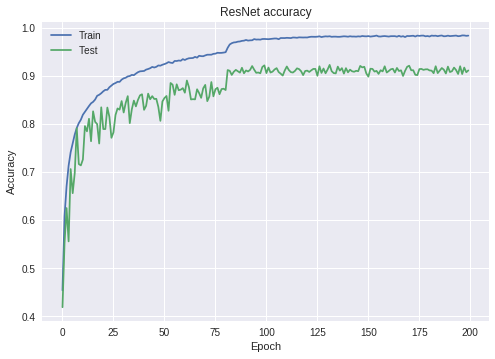

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('ResNet accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()